In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import io, transform

In [2]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [3]:
DATA_FOLDER = './data/'
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')
DATA_SIZE = 224

## Train Data

In [4]:
train = []
for category in CATEGORIES:
    filelist = [file for file in os.listdir(os.path.join(TRAIN_FOLDER, category)) if file.endswith('.png')]
    print('{} -> {}'.format(category, len(filelist)))
    for file in filelist:
        train.append([os.path.join(TRAIN_FOLDER, category, file), category, []])
train = pd.DataFrame(train, columns=['path', 'category', 'data'])
print(train.shape)
train.head(2)

Black-grass -> 263
Charlock -> 390
Cleavers -> 287
Common Chickweed -> 611
Common wheat -> 221
Fat Hen -> 475
Loose Silky-bent -> 654
Maize -> 221
Scentless Mayweed -> 516
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496
Sugar beet -> 385
(4750, 3)


,path,category,data
0,./data/train/Black-grass/5a1295fb4.png,Black-grass,[]
1,./data/train/Black-grass/d8afd58f3.png,Black-grass,[]


In [5]:
for i, file in tqdm(enumerate(train['path'])):  # 4750 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    train['data'][i] = img

0it [00:00, ?it/s]/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
4750it [03:08, 19.88it/s]


(224, 224, 3)


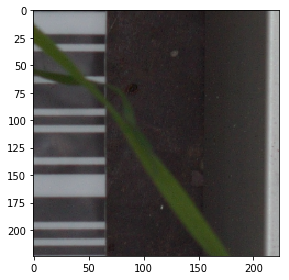

./data/train/Black-grass/5a1295fb4.png
Black-grass


In [7]:
print(train['data'][0].shape)
io.imshow(train['data'][0])
io.show()
print(train['path'][0])
print(train['category'][0])

## Test Data

In [8]:
test = []
filelist = [file for file in os.listdir(TEST_FOLDER) if file.endswith('.png')]
print('Test -> {}'.format(len(filelist)))
for file in filelist:
    test.append([os.path.join(TEST_FOLDER, file), file, "", []])
test = pd.DataFrame(test, columns=['path', 'file', 'category', 'data'])
print(test.shape)
test.head(2)

Test -> 794
(794, 4)


,path,file,category,data
0,./data/test/1b490196c.png,1b490196c.png,,[]
1,./data/test/85431c075.png,85431c075.png,,[]


In [9]:
for i, file in tqdm(enumerate(test['path'])):
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    test['data'][i] = img

0it [00:00, ?it/s]/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
794it [00:16, 48.22it/s]


(224, 224, 3)


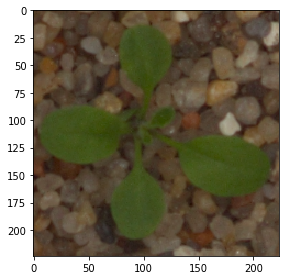

1b490196c.png


In [ ]:
print(test['data'][0].shape)
io.imshow(test['data'][0])
io.show()
print(test['file'][0])

## Using sum of absolute distance

In [ ]:
for testID in tqdm(range(len(test))):
    minSAD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['data'][testID] - train['data'][trainID]
        SAD = np.sum(np.abs(distance))
        a = test['data'][testID]
        b = train['data'][trainID]
        if SAD < minSAD or minSAD == -1:
            minSAD = SAD
            answerID = trainID
    test['category'][testID] = train['category'][answerID]

  0%|          | 0/794 [00:00<?, ?it/s]